Importing data

In [2]:
import pandas
from collections import Counter
from os import path
import json
from datetime import datetime

cwd = '../data'
data_path = path.join(cwd, '01.json')
student_path = path.join(cwd, 'students.txt')

exclude_author = ['AutoModerator', 'BlueArchive-ModTeam']

with open(data_path, "r", encoding='utf-8') as outfile:
    data = json.load(outfile)

data_df = pandas.DataFrame.from_dict(data, orient='index')
# [print(col) for col in data_df.columns]
filtered_df = data_df[['title', 'link_flair_text', 'ups', 'created_utc', 'comments', 'num_comments']]
filtered_df.created_utc = filtered_df.created_utc.apply(lambda x: datetime.fromtimestamp(x))
filtered_df.comments = filtered_df.comments.apply(lambda x: [comment['body'] for comment in x if comment['author'] not in exclude_author])
filtered_df.num_comments = filtered_df.comments.apply(lambda x: len(x))
filtered_df = filtered_df.loc[filtered_df['link_flair_text'].isin(['OC ART ', 'NON OC ART ', 'Comic/TL'])]

display(filtered_df.nlargest(10, 'num_comments'))
Counter(filtered_df.link_flair_text)

/tmp/ipykernel_899/4015878987.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas
/tmp/ipykernel_899/4015878987.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.created_utc = filtered_df.created_utc.apply(lambda x: datetime.fromtimestamp(x))
/tmp/ipykernel_899/4015878987.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

,title,link_flair_text,ups,created_utc,comments,num_comments
1abd8c5,"Sensei think about it, is it really worth it?!...",NON OC ART,1624,2024-01-26 16:57:38,"[Not with Saya running around., Hmmm 15 years ...",100
192s4dw,"Swimsuits, Seagulls, and Spite [Miyako, Miyu] ...",Comic/TL,1,2024-01-10 07:46:09,"[Miyako jelly, That glare is ice cold, Kinnota...",100
18ycyzd,Sensei is cheating (Yuuka by FluffyEbi01),NON OC ART,1,2024-01-04 22:18:04,"[You mean oxygen?, I glad i bought La Gallisso...",100
19787op,Preparing Karin for her make-up tests (by @miy...,Comic/TL,2069,2024-01-15 22:02:32,[…..okay looks like I got my work cut out for ...,99
1933xfl,My experience in the current banner ft. Sensei...,OC ART,1,2024-01-10 17:55:35,"[Same thing happened to me, except I pulled Io...",99
19byz68,"CONGRATULATIONS, SE-... oh... (Seia, Mika, Nag...",NON OC ART,1,2024-01-21 17:38:22,"[I'd say it's closer to ""I want to believe"" mi...",98
192e9be,What if Blue Archive was an X-COM clone? [Yuuk...,NON OC ART,1,2024-01-09 22:04:56,[Type 95's story in between GFL 1 and GFL 2 us...,98
199mmq6,"Shiroko: “Sensei, unlock the door.” (By: @mesi...",NON OC ART,1,2024-01-18 18:55:30,"[Shoroko:Open the door, Wierd way to paint., S...",92
196b0ey,"Eimi: “Gay” [Himari, Rio] (@anothercolor01)",NON OC ART,1189,2024-01-14 17:11:37,[Sensei: keep going my students I just gonna w...,91
199dlhp,"“Tsk, sensei, you’re back already?” (Arona, @S...",NON OC ART,1,2024-01-18 10:15:09,[Shifty? Oh crap I left Arona at The Outpost.....,89


Counter({'NON OC ART ': 1352, 'OC ART ': 516, 'Comic/TL': 418})

Raw text preprocessing

In [3]:
import re
import html

patterns = [
    r"!\[img\]\(emote\|t5_[a-z0-9]+\|\d+\)", # subreddit sticker/emote regex
    r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", # http(s) link regex
]

def clean(text):
    for pattern in patterns:
        text = re.sub(pattern, '', text)
    return html.unescape(text).lower()

data_text = { i: [v.title] + v.comments for i, v in filtered_df.iterrows()}
data_text = { i: clean('\n'.join(post_group)) for i, post_group in data_text.items()}

SpaCy model structuring

In [4]:
import spacy
from spacy.tokens import Token
from spacymoji import Emoji
from tqdm.notebook import tqdm

print(spacy.require_gpu())

ba_character_list = list()
with open(student_path, 'r', encoding='utf-8') as f:
    for l in f.readlines():
        ba_character_list.append(l.strip())

# alias groups - (main name, alias-1, alias-2, alias-3, ...)
alias_groups = [
    ('aris', 'alice', 'arisu', 'fridge', 'refrigerator'),
    ('hoshino', 'oji-san', 'ojisan', 'oji san'),
    ('yuuka', 'yuka', 'calculator', '100kg', '100 kg'),
    # ('sensei', 'senseis'), # cannot be detected as plural
    ('hina', 'hinature', 'hiniature')
]

ba_character_list.extend([j for i in alias_groups for j in i])

print('ba_character_list:', len(ba_character_list))
print(ba_character_list)


def BA_char_finder(tk):
    if (student := tk.text.lower()) in ba_character_list:
        for group in alias_groups:
            if student in group:
                student = group[0]
        return student
    else:
        return None


def get_nbors_(tk: spacy.tokens.token.Token, step: int, N: int):
    # step usually should be 1 or -1 - searching range step
    # N is the Nth search result to be returned

    if tk.is_sent_start and step < 0:
        return
    elif tk.is_sent_end and step > 0:
        return
    
    n = 1
    i = step
    while True:
        nbor = tk.nbor(i)
        if nbor.is_stop or nbor._.is_emoji or not nbor.is_alpha:
            pass
        else:
            if n == N:
                return nbor
            else:
                n += 1
                pass
        
        if nbor.is_sent_end or nbor.is_sent_start:
            return

        i += step


def get_nbors(tk):
    return ((
        (
        get_nbors_(tk, -1, 1), # l1
        get_nbors_(tk, 1, 1), # r1
        ),
        (
        get_nbors_(tk, -1, 2), # l2
        get_nbors_(tk, 1, 2), # r2
        ),
        # tk.sent
    ))

# for splitting sentences
@spacy.language.Language.component("custom_boundary")
def custom_boundary(doc):

    delimiters=['...', '\n']

    for token in doc[:-1]:
        if token.text in delimiters:
            doc[token.i+1].is_sent_start = True
    
    return doc


nlp = spacy.load('en_core_web_trf')
nlp.add_pipe("emoji", first=True)
nlp.add_pipe('custom_boundary', before='parser')

Token.set_extension("nbors", getter=get_nbors, force=True)
Token.set_extension("ba_characters", getter=BA_char_finder, force=True)

analysis = nlp.analyze_pipes(pretty=True)

print(spacy.require_gpu())
"""
Cuda compilation tools, release 11.5, V11.5.119
Build cuda_11.5.r11.5/compiler.30672275_0
"""

docs = list()
for t in tqdm(data_text.values()):
    docs.append(nlp(t))

True
ba_character_list: 179
['kayoko', 'sensei', 'master', 'arona', 'hare', 'nonomi', 'shokuhou', 'beatrice', 'iori', 'megu', 'meru', 'alice', 'kuzunoha', 'hifumi', 'yukari', 'tsurugi', 'nyanten-maru', 'phrenapates', 'saya', 'rumi', 'otogi', 'kaede', 'ibuki', 'iroha', 'eimi', 'karin', 'satsuki', 'akari', 'kai', 'sumomo', 'shiba', 'yuzu', 'makoto', 'wakamo', 'ayumu', 'haruna', 'saki', 'ruiko', 'rin', 'izumi', 'himari', 'niko', 'midori', 'ayane', 'aoi', 'gsc', 'erika', 'koharu', 'fubuki', 'kirino', 'takane', 'kisaki', 'akane', 'minori', 'hanae', 'maki', 'shinon', 'marina', 'decalcomanie', 'saten', 'reijo', 'sena', 'koyuki', 'reisa', 'renge', 'miku', 'mina', 'kaya', 'azusa', 'haruka', 'misaki', 'golconde', 'hibiki', 'mashiro', 'suzumi', 'shiroko', 'plana', 'maestro', 'kotama', 'mikoto', 'tomoe', 'sora', 'serina', 'umika', 'nagisa', 'sakurako', 'ako', 'momoka', 'niya', 'izuna', 'kurumi', 'junko', 'hiyori', 'shimiko', 'mimori', 'nodoka', 'atsuko', 'aru', 'kirara', 'hina', 'michiru', 'chihir

  0%|          | 0/2286 [00:00<?, ?it/s]

## FastText training
### preprocessing

In [6]:
def is_cleanable(tk: spacy.tokens.token.Token):
    # might(?) try and add emoji if that seems plausible
    if (tk.is_alpha and not tk.is_stop and not tk._.is_emoji) or tk.is_sent_end:
        return True
    else:
        return False

def preprocess_tk(tk: spacy.tokens.token.Token):
    if not tk.is_alpha:
        tk = '\n'
    elif tk.is_sent_end:
        tk = tk.lemma_.lower().strip()
        for group in alias_groups:
            if tk in group:
                tk = group[0]
        tk += '\n'
    else:
        tk = tk.lemma_.lower().strip()
        for group in alias_groups:
            if tk in group:
                tk = group[0]
        tk += ' '
    
    return tk


# preprocessed text for FastText
ft_preprocessed = [preprocess_tk(tk) for doc in docs for tk in doc if is_cleanable(tk)]
print('no. of tokens:', len(ft_preprocessed))
ft_preprocessed = ''.join(ft_preprocessed)
ft_preprocessed = re.sub(" +", " ", ft_preprocessed) # fixes double(or more) spaces
ft_preprocessed = re.sub("<[^>]*>", "", ft_preprocessed) # remove html tags

print('no. of comments:', ft_preprocessed.count('\n'))

ft_path = path.join(cwd, 'ft_preprocessed.txt')
with open(ft_path, 'w', encoding='utf-8') as f:
    f.write(ft_preprocessed)

no. of tokens: 307427
no. of comments: 98222


In [7]:
import fasttext
print(ft_path)
model = fasttext.train_unsupervised(ft_path, dim=300)  # pretrainedVectors=path.join(cwd, 'crawl-300d-2M.vec')

../data/ft_preprocessed.txt


Read 0M words
Number of words:  4848
Number of labels: 0
Progress: 100.0% words/sec/thread:   81545 lr:  0.000000 avg.loss:  2.583822 ETA:   0h 0m 0s


save vector as CSV (for tensorflow projector)

In [8]:
import csv

labels = model.get_labels()

with open(path.join(cwd, 'vectors.tsv'), 'w', encoding='utf-8') as f:
    writer = csv.writer(f, delimiter="\t")
    for label in labels:
        writer.writerow(list(model.get_word_vector(label)))

with open(path.join(cwd, 'labels.tsv'), 'w', encoding='utf-8') as f:
    writer = csv.writer(f, delimiter="\t")
    for label in labels:
        writer.writerow([label])

~~Inject the vocab vector table & re-run the pipeline~~ don't need this process

In [ ]:
nlp.vocab.reset_vectors(width=model.get_dimension())
[nlp.vocab.set_vector(word, model.get_word_vector(word)) for word in model.get_labels()]
nlp.vocab.deduplicate_vectors()

In [ ]:
docs = list()
for t in tqdm(data_text.values()):
    docs.append(nlp(t))

In [9]:
Counter([tk._.ba_characters for doc in docs for tk in doc if tk._.ba_characters]).most_common(10)

[('sensei', 5694),
 ('hina', 1502),
 ('yuuka', 1088),
 ('mika', 607),
 ('ako', 602),
 ('seia', 552),
 ('hoshino', 517),
 ('miyako', 489),
 ('aris', 473),
 ('shiroko', 443)]

get vec similarity for nbor words

In [10]:
from sklearn import preprocessing
import numpy as np

# will be the target ba_caharcter to calculate the similarity/score
target_character = 'hina'

# `cm` as in correlation matrix (not exactly a matrix but...)
cm_original = [tk._.nbors for doc in tqdm(docs) for tk in doc if tk._.ba_characters == target_character]

cm1_original = [j for i in (cm_original) for j in i[0] if j and (j._.ba_characters != target_character)] # bigram range
cm2_original = [j for i in (cm_original) for j in i[1] if j and (j._.ba_characters != target_character)] # trigram range

print('cm_1', cm1 := Counter([i.text for i in cm1_original]).most_common(500))
print('cm_2', cm2 := Counter([i.text for i in cm2_original]).most_common(500))

cm1_words = [i[0] for i in cm1]
cm2_words = [i[0] for i in cm2]

cm1_count = np.array([i[1] for i in cm1])
cm2_count = np.array([i[1] for i in cm2])

cm1_normalized_count = {k: v for k, v in zip(cm1_words, preprocessing.normalize([cm1_count])[0])}
cm2_normalized_count = {k: v for k, v in zip(cm2_words, preprocessing.normalize([cm2_count])[0])}


  0%|          | 0/2286 [00:00<?, ?it/s]

cm_1 [('sensei', 54), ('dress', 34), ('chan', 27), ('love', 26), ('ako', 24), ('like', 19), ('iroha', 19), ('cute', 19), ('hoshino', 18), ('swimsuit', 15), ('iori', 14), ('happy', 13), ('got', 13), ('gomen', 13), ('makoto', 11), ('deserves', 11), ('time', 11), ('best', 11), ('ft', 11), ('looks', 9), ('adorable', 9), ('probably', 9), ('wife', 9), ('day', 8), ('sleeping', 8), ('smile', 8), ('think', 8), ('know', 8), ('need', 8), ('good', 7), ('draw', 7), ('help', 7), ('strongest', 7), ('look', 7), ('seeing', 7), ('prefect', 7), ('feel', 7), ('gehenna', 6), ('art', 6), ('alt', 6), ('asmr', 6), ('beautiful', 6), ('right', 6), ('needs', 6), ('post', 6), ('terror', 6), ('getting', 6), ('girl', 6), ('event', 5), ('free', 5), ('gets', 5), ('poor', 5), ('translated', 5), ('dance', 5), ('reaction', 5), ('better', 5), ('yeah', 5), ('sorasaki', 5), ('s', 5), ('hair', 5), ('pulls', 5), ('yes', 4), ('going', 4), ('perfect', 4), ('waiting', 4), ('relationship', 4), ('student', 4), ('makes', 4), ('for

In [16]:
# TODO: make it so that it'll compare the raw vector values. - use cosine similarity
from scipy import spatial

def sort_dict(inp: dict) -> dict:
    return dict(sorted(inp.items(), key=lambda item: item[1], reverse=True))

def get_vec_similarity(word1, word2):
    return 1 - spatial.distance.cosine(model.get_word_vector(word1), model.get_word_vector(word2))\

def penalty(k: str, v): 
    # give a penalty to the score of students since students would naturally have higher similarity scores
    return v/2 if k in ba_character_list + ['chan', 'probably'] else v

cm1_vec = {word: get_vec_similarity(word, target_character) for word in cm1_words}
cm1_vec = {k: (v + cm1_normalized_count[k] * 10) for k, v in cm1_vec.items()}
cm1_vec = sort_dict(cm1_vec)
# display(cm1_vec)

cm2_vec = {word: get_vec_similarity(word, target_character) for word in cm2_words}
cm2_vec = {k: (v + cm2_normalized_count[k] * 10)/4 for k, v in cm2_vec.items()}
cm2_vec = sort_dict(cm2_vec)
# display(cm2_vec)

score = {k: penalty(k, v + cm2_vec.get(k, 0)) for k, v in cm1_vec.items()} # add up cm1 and cm2
score = sort_dict(score)

top_n = 10
for k in score:
    print(f'{k}: {score[k]}')
    top_n -= 1
    if top_n == 0: 
        break

dress: 4.205126482554398
sensei: 3.887976456382151
love: 3.822975848666765
like: 3.2589525603881486
cute: 3.021603015947443
swimsuit: 2.58182150863743
got: 2.522181009898195
gomen: 2.3566887493241246
happy: 2.287462416204722
ft: 2.2794837689315783


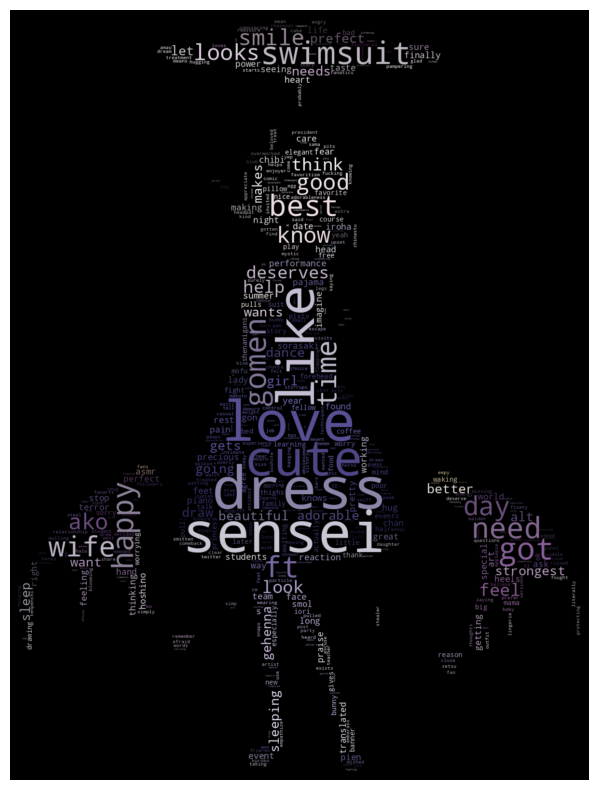

In [17]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from wordcloud import WordCloud, ImageColorGenerator

mask = np.array(Image.open(path.join(cwd, 'hina.png')))

wordcloud = WordCloud(random_state=1,
                      width = 2000, height = 2000,
                      background_color='black',
                      mask = mask,
                      max_words = 1000
                      ).generate_from_frequencies(score)

# Plot
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[10,10])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear") # wordcloud.recolor(color_func = lambda *args, **kwargs: "black") for single color
plt.axis("off")
plt.savefig(path.join(cwd, 'wordcloud.png'), dpi=2000)
plt.show()